# Speech Emotion Recognition

In [1]:
# Install Packages
!pip install librosa --upgrade --quiet
!pip install noisereduce --upgrade --quiet

In [1]:
import os
import csv
import opendatasets as od
from tqdm.auto import tqdm

from typing import List, Tuple, Dict, Optional
from math import floor
from itertools import cycle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
sns.set_style('darkgrid')

import noisereduce as nr
from IPython.display import Audio
import librosa
import librosa.display
import wave

from sklearn.linear_model import LogisticRegression, enet_path, lasso_path
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict, cross_val_score, KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder

import torch

import optuna

import warnings
warnings.filterwarnings ('ignore')
def fxn():
    warnings.warn("deprecated", DeprecationWarning)
with warnings.catch_warnings(action="ignore"):
    fxn()

In [2]:
# Parameters

DOWN_SR = 6000 # 22050
SECS = 3
MAX_FILES = 13000

ravdess = ['RAVDESS','data/ravdess-emotional-speech-audio']
tess = ['TESS','data/toronto-emotional-speech-set-tess']
cremad = ['CREMA-D','data/cremad/AudioWAV']
savee = ['SAVEE','data/savee-database/AudioData']
data_paths = [ravdess,tess,cremad,savee]

## Preprocessing

In [3]:
def ExtractLabel(audio_file_path,dataset_name):
    emotion = -1
    if (dataset_name == 'RAVDESS'):
        emotion = int(audio_file_path[7:8]) - 1
    if (dataset_name == 'TESS'):
        if '_neutral' in audio_file_path:
            emotion = 0
        if '_happy' in audio_file_path:
            emotion = 2
        if '_sad' in audio_file_path:
            emotion = 3
        if '_angry' in audio_file_path:
            emotion = 4
        if '_fear' in audio_file_path:
            emotion = 5
        if '_disgust' in audio_file_path:
            emotion = 6
        if '_ps' in audio_file_path:
            emotion = 7
    if (dataset_name == 'CREMA-D'):
        if '_NEU_' in audio_file_path:
            emotion = 0
        if '_HAP_' in audio_file_path:
            emotion = 2
        if '_SAD_' in audio_file_path:
            emotion = 3
        if '_ANG_' in audio_file_path:
            emotion = 4
        if '_FEA_' in audio_file_path:
            emotion = 5
        if '_DIS_' in audio_file_path:
            emotion = 6
    if (dataset_name == 'SAVEE'):
        if 'n' in audio_file_path:
            emotion = 0
        if 'h' in audio_file_path:
            emotion = 2
        if 'sa' in audio_file_path:
            emotion = 3
        if 'a' in audio_file_path:
            emotion = 4
        if 'f' in audio_file_path:
            emotion = 5
        if 'd' in audio_file_path:
            emotion = 6
        if 'su' in audio_file_path:
            emotion = 7
    return emotion

In [4]:
def FixSamples(sample,sr,max_seconds):
    leng = sr * 2 * max_seconds
    if len(sample) > leng:
        fix_sample = sample[len(sample)-leng:].reshape(leng,1)
    else:
        fix_sample = np.zeros([leng,1])
        fix_sample[leng-len(sample):] = sample.reshape(sample.shape[0],1)
    return fix_sample[:,0]

In [5]:
# Collect Data from audio files
ii=0
sample_data = np.zeros([MAX_FILES,SECS*2*DOWN_SR],dtype=np.float32)  # stores the features
labels = np.zeros([MAX_FILES,1],dtype=np.int8)  # stores the labels
for data_path in tqdm(data_paths,desc="Collecting Datasets"):
    root_dir = data_path[1]
    cpt = sum([len(d) for r, d, files in os.walk(root_dir)])+1
    for subdirs, dirs, files in tqdm(os.walk(root_dir), total=cpt, desc=f'Processing {data_path[0]} audio files', unit="file"):
        for file in files:
            if not '.wav' in file:
                continue
            audio_file_path = os.path.join(subdirs, file)
            sample, sr = librosa.load(audio_file_path,sr=DOWN_SR)
            sample = nr.reduce_noise(y=sample, sr=sr)
            if not np.isfinite(sample).all():
                continue
            sample, index = librosa.effects.trim(sample)
            sample_data[ii,:] = FixSamples(sample,DOWN_SR,SECS)
            labels[ii,:] = ExtractLabel(file,data_path[0])
            ii += 1
sample_data = sample_data[:ii,:]
labels = labels[:ii,:]
print(f'Data with total {sample_data.shape[0]} audio samples collected, with {sample_data.shape[1]} samples each.')

Processing RAVDESS audio files:   0%|          | 0/25 [00:00<?, ?file/s]

Processing TESS audio files:   0%|          | 0/16 [00:00<?, ?file/s]

Processing CREMA-D audio files:   0%|          | 0/1 [00:00<?, ?file/s]

Processing SAVEE audio files:   0%|          | 0/5 [00:00<?, ?file/s]

Data with total 12161 audio samples collected, with 36000 samples each.


In [6]:
# Combine some labels: Poor difference is found between "Neutal" and "Calm" emotions
labels = pd.DataFrame(labels, columns=['Emotion'])
labels['Emotion'].replace({0:0, 1:0, 2:1, 3:2, 4:3, 5:4, 6:5, 7:6}, inplace=True)
labels = labels.to_numpy()
labels_list = ['neutral', 'happy', 'sad', 'angry', 'fear', 'disgust', 'surprise']

In [17]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i])

def PlotLabelsHistogram(vY: np.ndarray, labels_list, hA: Optional[plt.Axes] = None ) -> plt.Axes:
    if hA is None:
        hF, hA = plt.subplots(figsize = (8, 6))
    vLabels, vCounts = np.unique(vY, return_counts = True)
    hA.bar(vLabels, vCounts, width = 0.9, align = 'center')
    addlabels(vLabels, vCounts)
    hA.set_title('Histogram of Classes / Labels')
    hA.set_xlabel('Class')
    hA.set_xticks(vLabels, labels_list)
    hA.set_ylabel('Count')
    return hA

def PlotSplitedDataHistogram(train_labels, test_labels):
    plt.figure(figsize=(16, 4))
    ax = plt.subplot(2,1,1)
    PlotLabelsHistogram(train_labels,labels_list,ax)
    ax = plt.subplot(2,1,2)
    PlotLabelsHistogram(test_labels,labels_list,ax)
    plt.show()

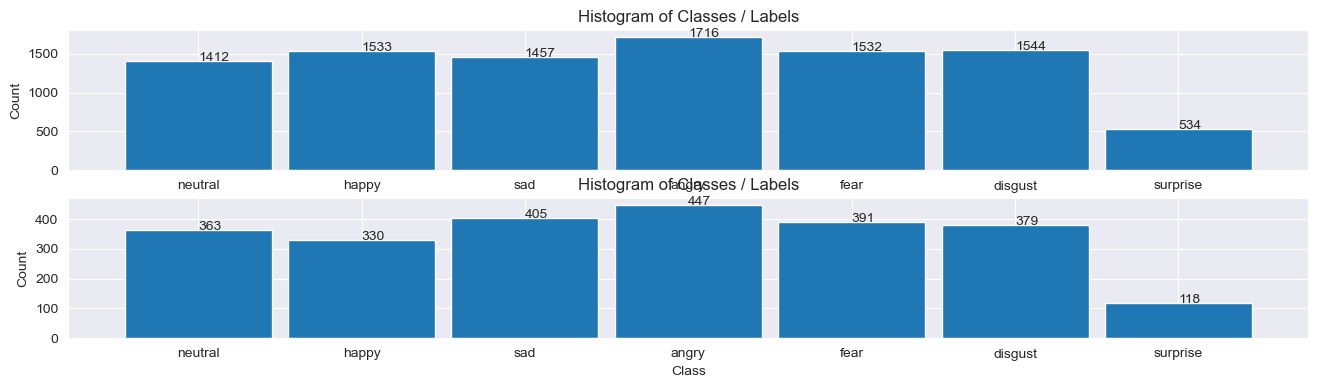

In [18]:
# Data samples split
train_data, test_data, train_labels, test_labels = train_test_split(sample_data, labels, train_size = 0.8, random_state = 512)
PlotSplitedDataHistogram(train_labels, test_labels)

## Augmentation

In [19]:
def Noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def TimeShift(data):
    shift_range = int(np.random.uniform(-5,5)*1000)
    return np.roll(data, shift_range)

def TimeStretch(data):
    stretch_factor = np.random.uniform(0.5,2)
    return librosa.effects.time_stretch(y=data, rate=stretch_factor)

def PitchScale(data,sr):
    pitch_factor = np.random.uniform(0.5,2)
    return librosa.effects.pitch_shift(y=data, sr=sr, n_steps=pitch_factor)

def InvertPolarity(data):
    return data * -1

def RandomGain(data):
    gain = np.random.uniform(0.2,1.5)
    return data * gain

def CreateAugmentedData(data,sr):
    data = TimeStretch(data)
    data = FixSamples(data,DOWN_SR,SECS)
    data = PitchScale(data,sr)
    data = TimeShift(data)
    data = Noise(data)
    data = RandomGain(data)
    data = InvertPolarity(data)
    return data

In [20]:
def AddAugmentionOnDataCollection(data,sr):
    data_with_augm = np.zeros([data.shape[0]*2,data.shape[1]],dtype=np.float32)
    for ii in tqdm(range(data.shape[0]), desc=f'Add augmentation data to audio samples'):
        augmented_data = CreateAugmentedData(data[ii,:],sr)
        data_with_augm[ii,:] = data[ii,:]
        data_with_augm[ii+data.shape[0],:] = augmented_data
    return data_with_augm

train_data = AddAugmentionOnDataCollection(train_data,DOWN_SR)
print(f'Train data added with Augmentation, shape = ({train_data.shape[0]},{train_data.shape[1]}).')

Add augmentation data to audio samples:   0%|          | 0/9728 [00:00<?, ?it/s]

Train data added with Augmentation, shape = (19456,36000).


In [21]:
def AddLabelsForAugmentedDataCollection(labels):
    labels_with_augm = np.zeros([labels.shape[0]*2,labels.shape[1]],dtype=np.int8)
    for ii in tqdm(range(labels.shape[0]), desc=f'Add Labels for augmentation data'):
        labels_with_augm[ii,:] = labels[ii,:]
        labels_with_augm[ii+labels.shape[0],:] = labels[ii,:]
    return labels_with_augm

train_labels = AddLabelsForAugmentedDataCollection(train_labels)
print(f'Train label added with Augmentation, shape = ({train_labels.shape[0]},{train_labels.shape[1]}).')

Add Labels for augmentation data:   0%|          | 0/9728 [00:00<?, ?it/s]

Train label added with Augmentation, shape = (19456,1).


## Feature Extraction

In [22]:
def ExtractFeatures_MFCC(sample,sr):
    mfcc = librosa.feature.mfcc(y=sample, sr=sr , n_mfcc=128, n_fft=886, win_length=886, hop_length=168)
    mfcc_mean = np.mean(mfcc,axis=1)
    #mfcc_var = np.var(mfcc,axis=1)
    #mfcc_med = np.median(mfcc,axis=1)
    mfcc_min = np.min(mfcc,axis=1)
    mfcc_max = np.max(mfcc,axis=1)
    #mfcc_sum = np.sum(mfcc,axis=1)
    features = np.concatenate((mfcc_mean, mfcc_min, mfcc_max),axis=0)
    return features

In [23]:
def ExtractFeaturesOnDataCollection(data,sr):
    features = ExtractFeatures_MFCC(data[0,:],sr)
    featured_data = np.zeros([data.shape[0],len(features)],dtype=np.float32)
    for ii in tqdm(range(data.shape[0]), desc=f'Extracting Features from audio samples'):
        featured_data[ii,:] = ExtractFeatures_MFCC(data[ii,:],sr)
    return featured_data

In [24]:
test_features = ExtractFeaturesOnDataCollection(test_data,DOWN_SR)
print(f'Test data with {test_features.shape[0]} samples and {test_features.shape[1]} features.')

Extracting Features from audio samples:   0%|          | 0/2433 [00:00<?, ?it/s]

Test data with 2433 samples and 384 features.


In [25]:
train_features = ExtractFeaturesOnDataCollection(train_data,DOWN_SR)
print(f'Train data with {train_features.shape[0]} samples and {train_features.shape[1]} features.')

Extracting Features from audio samples:   0%|          | 0/19456 [00:00<?, ?it/s]

Train data with 19456 samples and 384 features.


In [26]:
def Normalize(train_data,test_data):
    scaler = StandardScaler()
    train_data = scaler.fit_transform(train_data)
    test_data = scaler.transform(test_data)
    return train_data,test_data

def tScaler(data):
    m = data.mean(0, keepdim=True)
    s = data.std(0, unbiased=False, keepdim=True)
    data -= m
    data /= s
    return data

train_features_norm,test_features_norm = Normalize(train_features,test_features)

## Train Model

In [27]:
train_features_norm_rand = np.concatenate((train_features_norm, np.random.rand(train_features_norm.shape[0],1)),axis=1)
test_features_norm_rand = np.concatenate((test_features_norm, np.random.rand(test_features_norm.shape[0],1)),axis=1)

Prediction Train Accuracy: 99.98 %
Prediction Test Accuracy: 59.10 %
              precision    recall  f1-score   support

           0       0.60      0.64      0.62       363
           1       0.51      0.52      0.52       330
           2       0.55      0.64      0.59       405
           3       0.65      0.81      0.72       447
           4       0.66      0.37      0.47       391
           5       0.49      0.47      0.48       379
           6       0.91      0.75      0.82       118

    accuracy                           0.59      2433
   macro avg       0.62      0.60      0.60      2433
weighted avg       0.60      0.59      0.58      2433



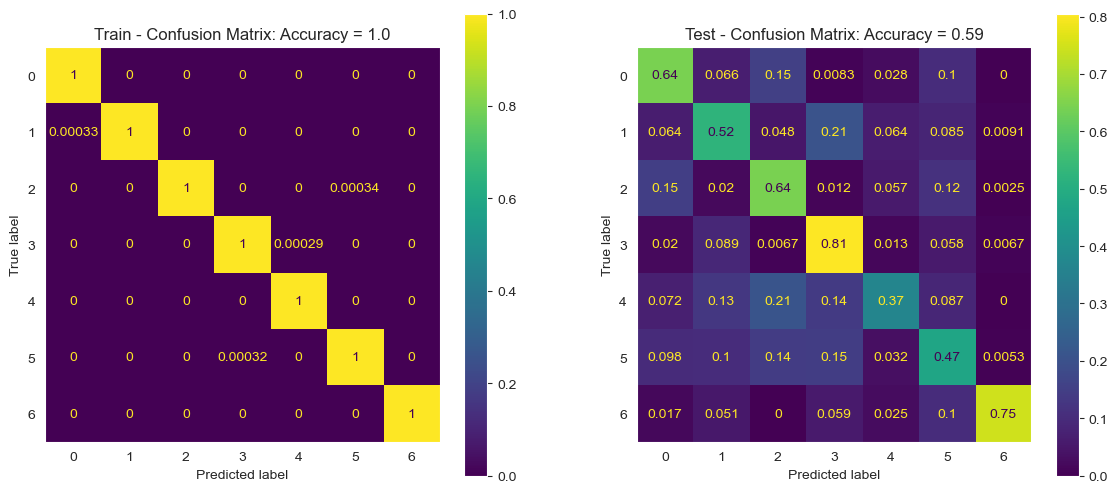

In [28]:
def PlotConfusionMatrix(vY: np.ndarray, vYPred: np.ndarray, normMethod: str = 'true', hA: Optional[plt.Axes] = None, 
                        lLabels: Optional[List] = None, dScore: Optional[Dict] = None, titleStr: str = 'Confusion Matrix', 
                        xLabelRot: Optional[int] = None, valFormat: Optional[str] = None) -> Tuple[plt.Axes, np.ndarray]:
    # Calculation of Confusion Matrix
    mConfMat = confusion_matrix(vY, vYPred, normalize = normMethod)
    oConfMat = ConfusionMatrixDisplay(mConfMat, display_labels = lLabels)
    oConfMat = oConfMat.plot(ax = hA, values_format = valFormat)
    hA = oConfMat.ax_
    if dScore is not None:
        titleStr += ':'
        for scoreName, scoreVal in  dScore.items():
            titleStr += f' {scoreName} = {scoreVal:0.2},'
        titleStr = titleStr[:-1]
    hA.set_title(titleStr)
    hA.grid(False)
    if xLabelRot is not None:
        for xLabel in hA.get_xticklabels():
            xLabel.set_rotation(xLabelRot)
    return hA, mConfMat

def TestClassificationModel(train_data,train_labels,test_data,test_labels):
    oModel = RandomForestClassifier(n_estimators=100,min_samples_split=6,random_state=1,n_jobs=-1)
    oModel.fit(train_data,train_labels)
    train_labels_pred = oModel.predict(train_data)
    train_accuracy = oModel.score(train_data,train_labels)
    test_labels_pred = oModel.predict(test_data)
    test_accuracy = oModel.score(test_data,test_labels)
    report = classification_report(test_labels,test_labels_pred)
    print(f'Prediction Train Accuracy: {train_accuracy*100:3.2f} %')
    print(f'Prediction Test Accuracy: {test_accuracy*100:3.2f} %')
    print(f'{report}')

    plt.figure(figsize=(14, 6))
    ax = plt.subplot(1,2,1)
    lConfMatTrainData = {'vY': train_labels, 'vYPred': train_labels_pred, 'hA': ax, 'dScore': {'Accuracy': train_accuracy}, 'titleStr': 'Train - Confusion Matrix'}
    PlotConfusionMatrix(**lConfMatTrainData)
    ax = plt.subplot(1,2,2)
    lConfMatTestData = {'vY': test_labels, 'vYPred': test_labels_pred, 'hA': ax, 'dScore': {'Accuracy': test_accuracy}, 'titleStr': 'Test - Confusion Matrix'}
    PlotConfusionMatrix(**lConfMatTestData)
    plt.show()
    return report, test_accuracy, oModel

def TrainModel(train_data,train_labels,test_data,test_labels):
    oModel = RandomForestClassifier(n_estimators=100,min_samples_split=6,random_state=1,n_jobs=-1)
    oModel.fit(train_data,train_labels)
    accuracy = oModel.score(test_data,test_labels)
    return accuracy

report, score, model = TestClassificationModel(train_features_norm_rand,train_labels,test_features_norm_rand,test_labels)

## Features Selection

In [29]:
def Numpy2Pandas(data):
    data_len = data.shape[1]
    columns = []
    for ii in range(data_len):
        columns.append(f'F{ii}')
    return pd.DataFrame(data, columns=columns)

def FeaturesSelect(train_features,test_features,features,features_threshold):
    weak_features_indexes = np.where(features < features_threshold)[0]
    train_features_selected = np.delete(train_features,weak_features_indexes,axis=1)
    test_features_selected = np.delete(test_features,weak_features_indexes,axis=1)
    n_feat = train_features_selected.shape[1]
    return train_features_selected,test_features_selected,n_feat

<BarContainer object of 384 artists>

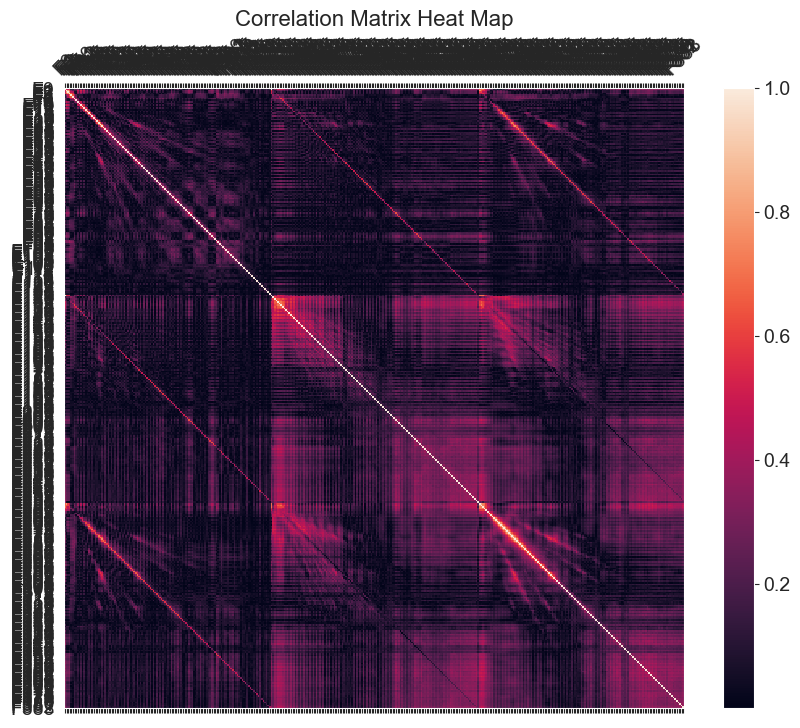

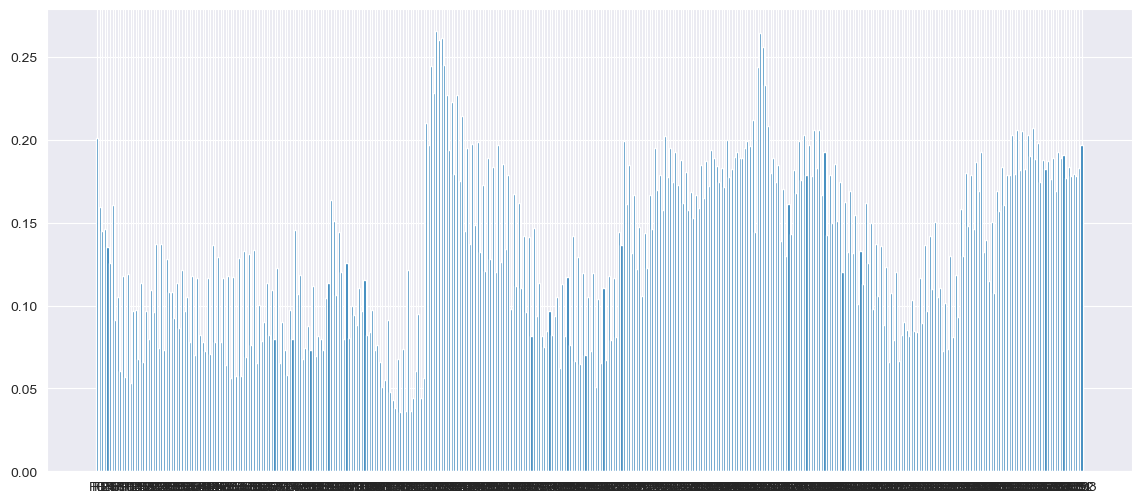

In [30]:
def PlotCorrMap(data): # ,labels
    f = plt.figure(figsize=(10, 8))
    corr_mat = data.corr().abs()
    plt.matshow(corr_mat, fignum=f.number)
    plt.xticks(range(data.select_dtypes(['number']).shape[1]), data.select_dtypes(['number']).columns, fontsize=14, rotation=45)
    plt.yticks(range(data.select_dtypes(['number']).shape[1]), data.select_dtypes(['number']).columns, fontsize=14)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title('Correlation Matrix Heat Map', fontsize=16)
    plt.grid(None)
    return corr_mat

def GetFeaturesCorr(corr_mat):
    x_corr = corr_mat.mean(axis=0).to_numpy()
    y_corr = corr_mat.mean(axis=1).to_numpy()
    corr_vec = (x_corr+y_corr)/2
    corr_vec = Numpy2Pandas(corr_vec.reshape(corr_vec.shape[0],1).T)
    return corr_vec

def TestByCorrThreshold(threshold):
    # Remove weak features
    train_features_selected,test_features_selected,n_feat = FeaturesSelect(train_features_norm,test_features,corr_vec.to_numpy()[0,:],threshold)
    # Test selected features
    accuracy = TrainModel(train_features_selected,train_labels,test_features_selected,test_labels)
    return accuracy, n_feat

pd_train_features = Numpy2Pandas(train_features_norm)
corr_mat = PlotCorrMap(pd_train_features)
corr_vec = GetFeaturesCorr(corr_mat)

plt.figure(figsize=(14, 6))
plt.bar(x = corr_vec.columns, height = corr_vec.to_numpy()[0])

#lib.PlotPairAllFeature(train_data,train_labels,train_data.shape[1])

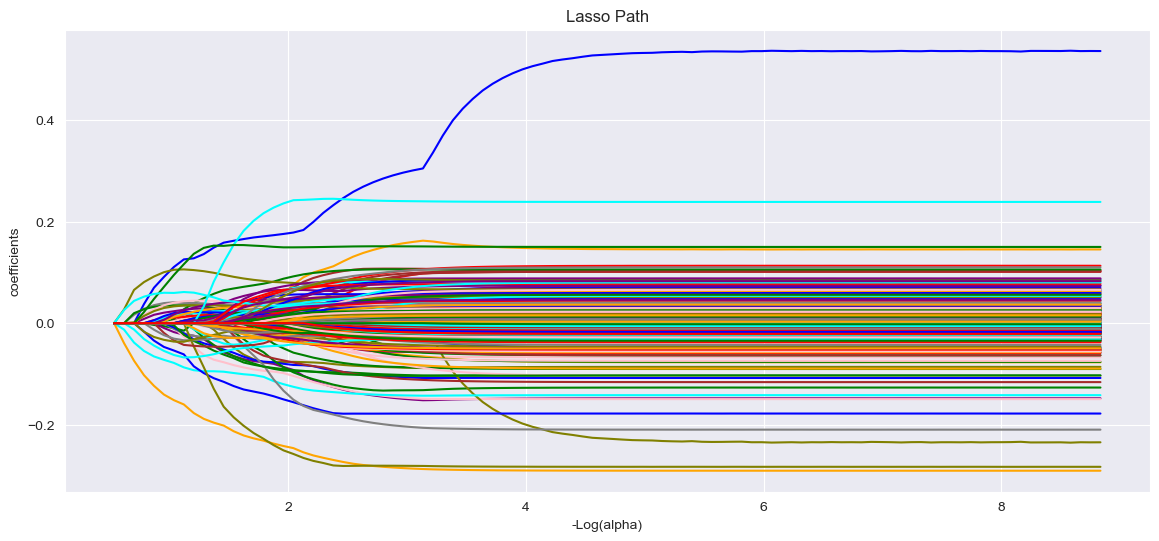

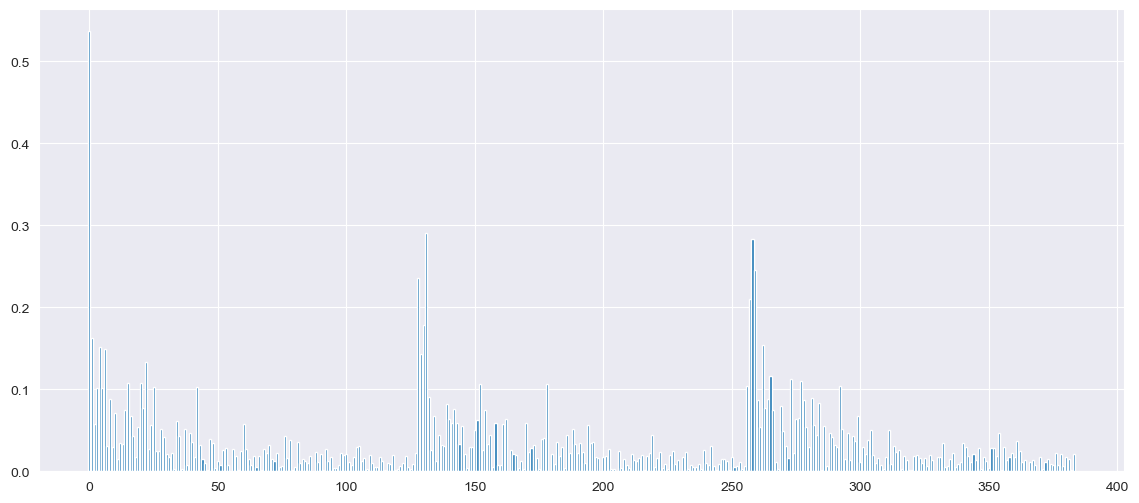

In [31]:
def PlotLassoPath(X,y,eps):
    # eps = 5e-3  # the smaller it is the longer is the path
    if isinstance(X, pd.DataFrame):
        X = X.to_numpy()
    if isinstance(y, pd.DataFrame):
        y = y.to_numpy()
    y = y[:,0]

    alphas_lasso, coefs_lasso, _ = lasso_path(X, y, eps=eps)

    plt.figure(figsize=(14, 6))
    colors = cycle(['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan'])
    neg_log_alphas_lasso = -np.log10(alphas_lasso)
    for coef_l, c in zip(coefs_lasso, colors):
        l1 = plt.plot(neg_log_alphas_lasso, coef_l, c=c)
    plt.xlabel("-Log(alpha)")
    plt.ylabel("coefficients")
    plt.title("Lasso Path")
    
    plt.figure(figsize=(14, 6))
    pd_coefs_lasso = Numpy2Pandas(coefs_lasso)
    lasso_max = pd_coefs_lasso.abs().max(axis=1)
    plt.bar(x = lasso_max.index, height = lasso_max)

    # best_features = lasso_max.sort_values(ascending=False).index
    return lasso_max

def TestByLassoThreshold(threshold):
    # Remove weak features
    train_features_selected,test_features_selected,n_feat = FeaturesSelect(train_features_norm,test_features,lasso_max,threshold)
    # Test selected features
    accuracy = TrainModel(train_features_selected,train_labels,test_features_selected,test_labels)
    return accuracy, n_feat

lasso_max = PlotLassoPath(train_features_norm,train_labels,eps=5e-9)

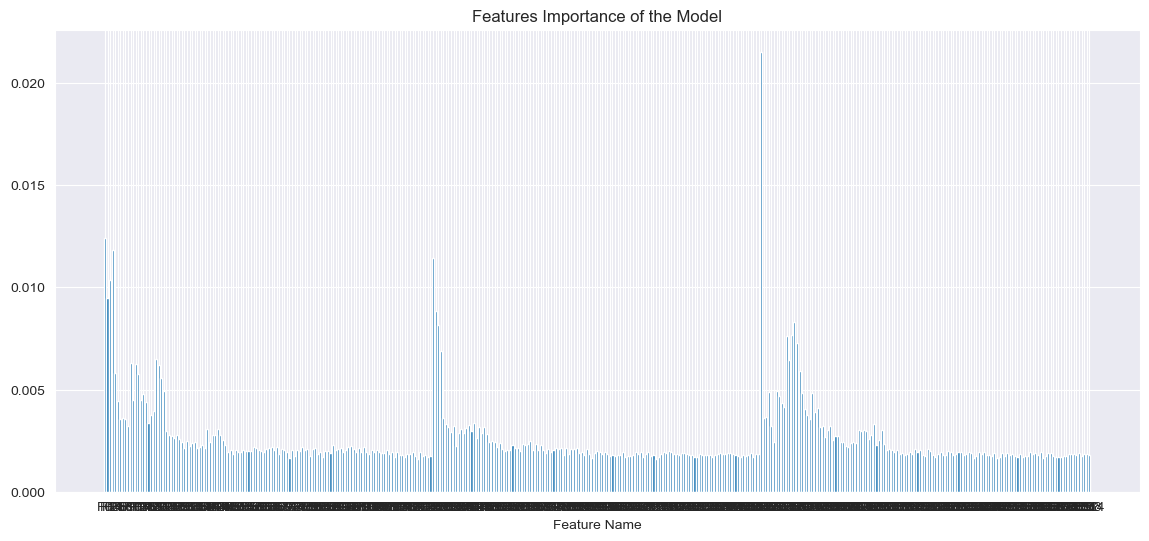

In [32]:
def FeaturesImportance(model,data):
    dfData = Numpy2Pandas(data)
    vFeatImportance = model.feature_importances_
    fig = plt.figure(figsize=(14, 6))
    plt.bar(x = dfData.columns, height = vFeatImportance)
    plt.title('Features Importance of the Model')
    plt.xlabel('Feature Name')
    fig.show()
    return vFeatImportance

def TestByFeatureImportanceThreshold(threshold):
    # Remove weak features
    train_features_selected,test_features_selected,n_feat = FeaturesSelect(train_features_norm_rand,test_features_norm_rand,feature_importance,threshold)
    # Test selected features
    accuracy = TrainModel(train_features_selected,train_labels,test_features_selected,test_labels)
    return accuracy, n_feat

feature_importance = FeaturesImportance(model,train_features_norm_rand)
feature_importance_min = feature_importance[len(feature_importance)-1]

In [33]:
def oFeatureImportanceThreshold(trial):
    feature_importance_threshold = trial.suggest_float("thr", feature_importance_min, np.max(feature_importance)-1e-12)
    score, n_feat = TestByFeatureImportanceThreshold(feature_importance_threshold)
    return score

study_name="FeatureImportanceThreshold"
study = optuna.create_study(
    study_name=study_name,
    storage=f"sqlite:///{study_name}.db",  # Specify the storage URL here.
    direction='maximize'
)

[I 2024-05-13 14:31:28,738] A new study created in RDB with name: FeatureImportanceThreshold


In [34]:
study.optimize(oFeatureImportanceThreshold, n_trials=100)
score, n_feat = TestByFeatureImportanceThreshold(study.best_params['thr'])

print(f"Best score: {score} (n_feat: {n_feat}, threshold: {study.best_params})")

[I 2024-05-13 14:31:31,005] Trial 0 finished with value: 0.5815865187011919 and parameters: {'thr': 0.006073882137725666}. Best is trial 0 with value: 0.5815865187011919.
[I 2024-05-13 14:31:31,989] Trial 1 finished with value: 0.22441430332922319 and parameters: {'thr': 0.0192014176267873}. Best is trial 0 with value: 0.5815865187011919.
[I 2024-05-13 14:31:35,266] Trial 2 finished with value: 0.6025482942868886 and parameters: {'thr': 0.0037779844915269015}. Best is trial 2 with value: 0.6025482942868886.
[I 2024-05-13 14:31:36,248] Trial 3 finished with value: 0.22441430332922319 and parameters: {'thr': 0.0167533739221055}. Best is trial 2 with value: 0.6025482942868886.
[I 2024-05-13 14:31:41,435] Trial 4 finished with value: 0.60583641594739 and parameters: {'thr': 0.00229751351390936}. Best is trial 4 with value: 0.60583641594739.
[I 2024-05-13 14:31:42,603] Trial 5 finished with value: 0.22441430332922319 and parameters: {'thr': 0.013537295659892238}. Best is trial 4 with value:

Best score: 0.6177558569667078 (n_feat: 99, threshold: {'thr': 0.0024551901257208247})


(19456, 99)

(2433, 99)

Prediction Train Accuracy: 99.98 %
Prediction Test Accuracy: 61.78 %
              precision    recall  f1-score   support

           0       0.61      0.70      0.65       363
           1       0.52      0.52      0.52       330
           2       0.60      0.66      0.63       405
           3       0.68      0.80      0.74       447
           4       0.69      0.42      0.53       391
           5       0.52      0.51      0.52       379
           6       0.88      0.76      0.82       118

    accuracy                           0.62      2433
   macro avg       0.64      0.63      0.63      2433
weighted avg       0.62      0.62      0.61      2433



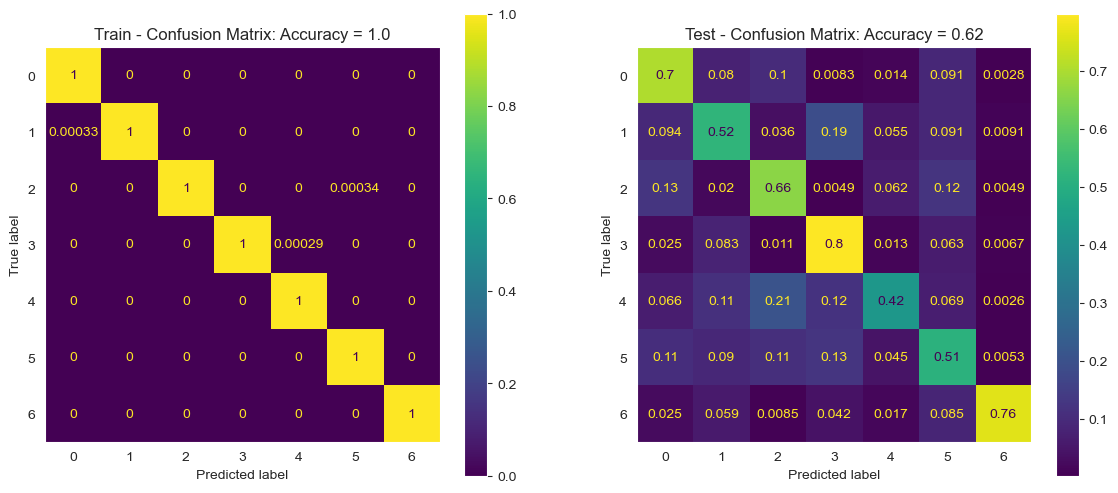

In [36]:
# Remove weak features
train_features_selected,test_features_selected,n_feat = FeaturesSelect(train_features_norm_rand,test_features_norm_rand,feature_importance,study.best_params['thr'])
display(train_features_selected.shape)
display(test_features_selected.shape)

# Test selected features
report, score, model = TestClassificationModel(train_features_selected,train_labels,test_features_selected,test_labels)

In [37]:
# save data to files

def SaveCsv(filename,np_data):
    pd.DataFrame(np_data).to_csv(filename)

SaveCsv('train_features_selected.csv',train_features_selected)
SaveCsv('train_labels.csv',train_labels)
SaveCsv('test_features_selected.csv',test_features_selected)
SaveCsv('test_labels.csv',test_labels)

## Find best Model with best Hyperparameters

### Load Selected Features

In [ ]:
# load data from files

def LoadCsv(filename):
    return pd.read_csv(filename).to_numpy()[:,1:]

train_features_selected = LoadCsv('train_features_selected.csv')
train_labels = LoadCsv('train_labels.csv')
test_features_selected = LoadCsv('test_features_selected.csv')
test_labels = LoadCsv('test_labels.csv')

# Test selected features
report, score, model = TestClassificationModel(train_features_selected,train_labels,test_features_selected,test_labels)

In [ ]:
def CrossValidation(model,numFold):
    trainAccArr = cross_val_score(
        model, 
        train_features_selected, 
        train_labels, 
        cv = StratifiedKFold(numFold, shuffle = True),
        n_jobs=-1)
    trainAcc = np.mean(trainAccArr)
    return trainAcc

def TestBestModel(model):
    model.fit(train_features_selected,train_labels)
    train_labels_pred = model.predict(train_features_selected)
    train_accuracy = model.score(train_features_selected,train_labels)
    test_labels_pred = model.predict(test_features_selected)
    test_accuracy = model.score(test_features_selected,test_labels)
    report = classification_report(test_labels,test_labels_pred)
    print(f'Prediction Train Accuracy: {train_accuracy*100:3.2f} %')
    print(f'Prediction Test Accuracy: {test_accuracy*100:3.2f} %')
    print(f'{report}')
    plt.figure(figsize=(14, 6))
    ax = plt.subplot(1,2,1)
    lConfMatTrainData = {'vY': train_labels, 'vYPred': train_labels_pred, 'hA': ax, 'dScore': {'Accuracy': train_accuracy}, 'titleStr': 'Train - Confusion Matrix'}
    lib.PlotConfusionMatrix(**lConfMatTrainData)
    ax = plt.subplot(1,2,2)
    lConfMatTestData = {'vY': test_labels, 'vYPred': test_labels_pred, 'hA': ax, 'dScore': {'Accuracy': test_accuracy}, 'titleStr': 'Test - Confusion Matrix'}
    lib.PlotConfusionMatrix(**lConfMatTestData)
    plt.show()

### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

study_name="Search_KNN_1"
study_KNN = optuna.create_study(
    study_name=study_name,
    storage=f"sqlite:///{study_name}.db",  # Specify the storage URL here.
    direction='maximize'
)

def oSearch_KNN(trial):
    n_neighbors = trial.suggest_int("n_neighbors", 2, 100)
    weights = trial.suggest_categorical("weights", ["uniform", "distance"])
    p = trial.suggest_int("p", 1, 4)
    numFold = trial.suggest_int("numFold", 10, 20)
    trainAcc = CrossValidation(KNeighborsClassifier(n_neighbors=n_neighbors,weights=weights,p=p,n_jobs=-1),numFold)
    return trainAcc

In [ ]:
study_KNN.optimize(oSearch_KNN, n_trials=100)
print(f"Best score: {study_KNN.best_value}, Best Params: {study_KNN.best_params}")

# Test best model
TestBestModel(KNeighborsClassifier(n_neighbors=study_KNN.best_params['n_neighbors'],weights=study_KNN.best_params['weights'],p=study_KNN.best_params['p'],n_jobs=-1))

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

study_name="Search_LogisticRegression_7"
study_LogisticRegression = optuna.create_study(
    study_name=study_name,
    storage=f"sqlite:///{study_name}.db",  # Specify the storage URL here.
    direction='maximize'
)

def oSearch_LogisticRegression(trial):
    penalty = trial.suggest_categorical("penalty", ["l1", "l2", "elasticnet"])
    C = trial.suggest_int("C", 1, 100)
    multi_class = trial.suggest_categorical("multi_class", ["auto", "ovr", "multinomial"])
    numFold = trial.suggest_int("numFold", 10, 20)
    if penalty == 'l1':
        l1_ratio = 1
    elif penalty == 'l2':
        l1_ratio = 0
    else:
        l1_ratio = 0.5
    trainAcc = CrossValidation(LogisticRegression(penalty=penalty,C=C,multi_class=multi_class,max_iter=1000,l1_ratio=l1_ratio,solver='saga',random_state=1,n_jobs=-1),numFold)
    return trainAcc

In [ ]:
study_LogisticRegression.optimize(oSearch_LogisticRegression, n_trials=100)
print(f"Best score: {study_LogisticRegression.best_value}, Best Params: {study_LogisticRegression.best_params}")

if study_LogisticRegression.best_params['penalty'] == 'l1':
    l1_ratio = 1
elif study_LogisticRegression.best_params['penalty'] == 'l2':
    l1_ratio = 0
else:
    l1_ratio = 0.5

# Test best model
TestBestModel(LogisticRegression(penalty=study_LogisticRegression.best_params['penalty'],C=study_LogisticRegression.best_params['C'],multi_class=study_LogisticRegression.best_params['multi_class'],max_iter=1000,l1_ratio=l1_ratio,solver='saga',random_state=1,n_jobs=-1))

### SVM

In [ ]:
from sklearn.svm import SVC

study_name="Search_SVM_2"
study_SVM = optuna.create_study(
    study_name=study_name,
    storage=f"sqlite:///{study_name}.db",  # Specify the storage URL here.
    direction='maximize'
)

def oSearch_SVM(trial):
    C = trial.suggest_int("C", 1, 100)
    kernel = trial.suggest_categorical("kernel", ["linear", "poly", "rbf", "sigmoid"])
    degree = trial.suggest_int("degree", 2, 20)
    gamma = trial.suggest_categorical("gamma", ["scale", "auto"])
    decision_function_shape = trial.suggest_categorical("decision_function_shape", ["ovo", "ovr"])
    numFold = trial.suggest_int("numFold", 10, 20)
    trainAcc = CrossValidation(SVC(C=C,kernel=kernel,degree=degree,gamma=gamma,decision_function_shape=decision_function_shape,random_state=1),numFold)
    return trainAcc

In [ ]:
study_SVM.optimize(oSearch_SVM, n_trials=100)
print(f"Best score: {study_SVM.best_value}, Best Params: {study_SVM.best_params}")

# Test best model
TestBestModel(SVC(C=study_SVM.best_params['C'],kernel=study_SVM.best_params['kernel'],degree=study_SVM.best_params['degree'],gamma=study_SVM.best_params['gamma'],decision_function_shape=study_SVM.best_params['decision_function_shape'],random_state=1))

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

study_name="Search_RandomForest_1"
study_RandomForest = optuna.create_study(
    study_name=study_name,
    storage=f"sqlite:///{study_name}.db",  # Specify the storage URL here.
    direction='maximize'
)

def oSearch_RandomForest(trial):
    n_estimators = trial.suggest_int("n_estimators", 10, 1000)
    criterion = trial.suggest_categorical("criterion", ["gini", "entropy", "log_loss"])
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    numFold = trial.suggest_int("numFold", 10, 20)
    trainAcc = CrossValidation(RandomForestClassifier(n_estimators=n_estimators,criterion=criterion,min_samples_split=min_samples_split,max_features=None,random_state=1,n_jobs=-1),numFold)
    return trainAcc

In [ ]:
study_RandomForest.optimize(oSearch_RandomForest, n_trials=100)
print(f"Best score: {study_RandomForest.best_value}, Best Params: {study_RandomForest.best_params}")

# Test best model
TestBestModel(RandomForestClassifier(n_estimators=study_RandomForest.best_params['n_estimators'],criterion=study_RandomForest.best_params['criterion'],min_samples_split=study_RandomForest.best_params['min_samples_split'],max_features=None,random_state=1,n_jobs=-1))

### XGBoost

In [ ]:
import xgboost as xgb

study_name="Search_XGBoost_1"
study_XGBoost = optuna.create_study(
    study_name=study_name,
    storage=f"sqlite:///{study_name}.db",  # Specify the storage URL here.
    direction='maximize'
)

def oSearch_XGBoost(trial):
    n_estimators = trial.suggest_int("n_estimators", 10, 1000)
    criterion = trial.suggest_categorical("criterion", ["gini", "entropy", "log_loss"])
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    numFold = trial.suggest_int("numFold", 10, 20)

    dtrain = xgb.DMatrix(train_features_selected, label=train_labels)

    evallist = [(dtrain, 'train'), (dtest, 'eval')]
    bst = xgb.train(param, dtrain, num_round, evallist)

    trainAcc = CrossValidation(RandomForestClassifier(n_estimators=n_estimators,criterion=criterion,min_samples_split=min_samples_split,max_features=None,random_state=1,n_jobs=-1),numFold)
    return trainAcc

In [ ]:
study_XGBoost.optimize(oSearch_XGBoost, n_trials=100)
print(f"Best score: {study_XGBoost.best_value}, Best Params: {study_XGBoost.best_params}")

# Test best model
TestBestModel(RandomForestClassifier(n_estimators=study_XGBoost.best_params['n_estimators'],criterion=study_XGBoost.best_params['criterion'],min_samples_split=study_XGBoost.best_params['min_samples_split'],max_features=None,random_state=1,n_jobs=-1))